# Классификация знаков Дорожного Движения

In [1]:
# !pip install natsort

In [2]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from skimage import transform

print(f'Tensorflow version {tf.__version__}')
print(f'GPU is {"ON" if tf.compat.v1.config.experimental.list_physical_devices("GPU") else "OFF" }')


import numpy as np
import matplotlib, random
import matplotlib.pyplot as plt
import pandas as pd 
import cv2
import os

from imutils import paths
import os
import pathlib
import LRFinder
from natsort import natsorted

Tensorflow version 2.10.0
GPU is ON


In [3]:
data = []
labels = []
sumu =0
start = 0
input_size = (60,60)
path = "./New_Dataset/special_instructions_signs/"
num_classes = len(os.listdir(path))
for file_number in os.listdir(path):
    path2 = str(path+file_number)
    num = 0
    count=0
    for file_number_2 in os.listdir(path2):
        path3 = str(path2 + '/' + file_number_2)
#         if count == 350: break
        count = count+1
        imagepath = (path3)
#         print(imagepath)
        image = cv2.imread(imagepath, 1) ## Считываем изображение
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB) ## переводим в оттенки серого
        image = transform.resize(image, input_size)
        data.append(image)

        label = file_number
        labels.append(label)
    num = num + count
    sumu = sumu+count
    print(label, num)
print('all',sumu)

110 461
111 245
112 281
113 209
114 569
115 353
116 605
117 209
118 209
119 281
120 209
121 173
122 173
123 173
124 209
125 209
126 245
127 173
128 173
129 209
130 1541
131 425
132 245
133 641
134 209
135 677
136 353
137 353
138 1325
139 1073
140 281
141 245
142 281
143 209
144 281
145 173
146 605
147 209
all 14494


In [4]:
df = pd.DataFrame({'labels': labels})
print(df.nunique())
print(df['labels'].value_counts())

labels    38
dtype: int64
130    1541
138    1325
139    1073
135     677
133     641
146     605
116     605
114     569
110     461
131     425
137     353
136     353
115     353
119     281
142     281
144     281
112     281
140     281
141     245
126     245
111     245
132     245
134     209
143     209
129     209
125     209
124     209
120     209
118     209
117     209
113     209
147     209
128     173
127     173
123     173
122     173
121     173
145     173
Name: labels, dtype: int64


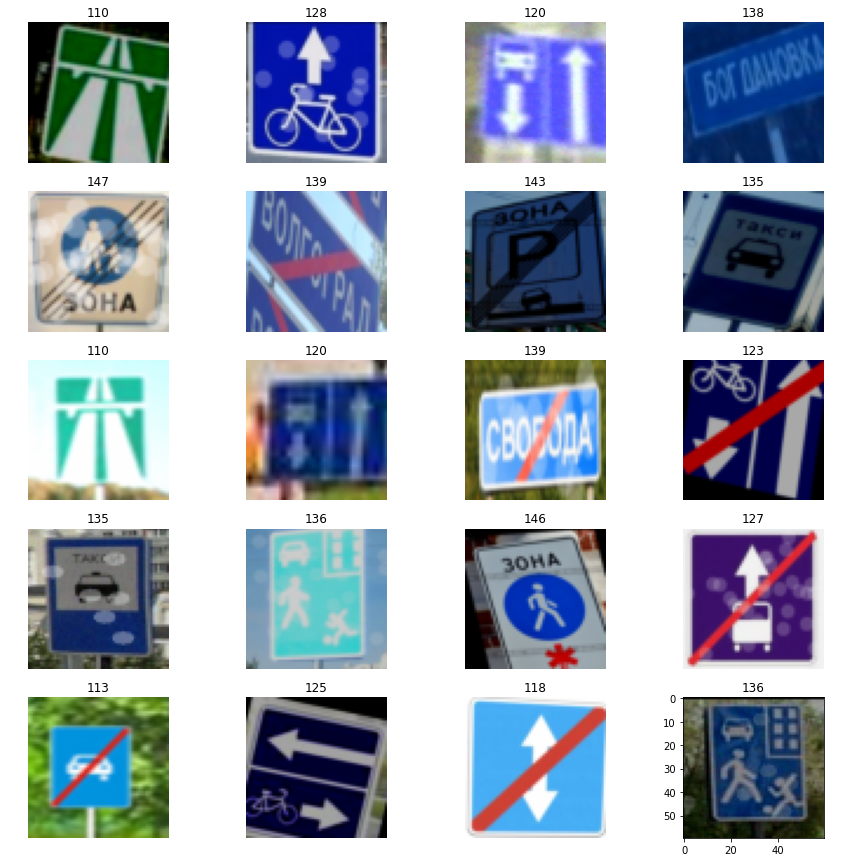

In [5]:
fig = plt.figure(figsize=(15, 15))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    z = random.randint(1,len(labels))
    plt.axis('off') 
    fig.add_subplot(rows, columns, i)
    plt.title(labels[z])
    plt.imshow(data[z])
plt.show()

In [6]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
labels = le.fit_transform(labels)


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, labels, random_state = 42, test_size = 0.3, stratify = labels)

from keras.utils import to_categorical
#Converting the labels into one hot encoding
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [7]:
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D,UpSampling2D,ZeroPadding2D, Dense, Flatten, Dropout, BatchNormalization , Input, ReLU
from keras import initializers
import math
import tensorflow_addons as tfa

from keras.optimizers import SGD, Adam

# opt = SGD(learning_rate=0.008)
opt = Adam(learning_rate=0.0001)
# opt = SGD()
initializer = initializers.RandomUniform(-1.0 / math.sqrt(512), 1.0 / math.sqrt(512), seed=42)

model = Sequential()
model.add(Input(shape=np.array(X_train).shape[1:]))

# model.add(ZeroPadding2D(padding=1))
model.add(Conv2D(filters=32, kernel_size=3, activation = 'swish'))
# model.add(ReLU())

model.add(MaxPool2D(pool_size=2))
model.add(Dropout(rate=0.05))

model.add(ZeroPadding2D(padding=1))
model.add(Conv2D(filters=64, kernel_size=3, activation = 'swish'))
# model.add(ReLU())

model.add(MaxPool2D(pool_size=2))
model.add(Dropout(rate=0.1))

# model.add(ZeroPadding2D(padding=1))
model.add(Conv2D(filters=128, kernel_size=3, activation = 'swish'))
# model.add(ReLU())

model.add(MaxPool2D(pool_size=2))
model.add(Dropout(rate=0.15))

# model.add(ZeroPadding2D(padding=2))
model.add(Conv2D(filters=256, kernel_size=5, activation = 'swish'))
# model.add(ReLU())

model.add(MaxPool2D(pool_size=2))
model.add(Dropout(rate=0.2))

model.add(BatchNormalization (momentum=0.9, epsilon=1e-5))


model.add(Flatten()) # по кол-ву пикселей из 2д в 1д
model.add(Dense(128, activation='swish')) # кол-во нейронов в слое
model.add(Dense(64, activation='swish')) # кол-во нейронов в слое
model.add(Dense(32, activation='swish')) # кол-во нейронов в слое
model.add(Dense(num_classes, kernel_initializer=initializer, bias_initializer=initializer, activation='softmax'))  # кол-во нейронов на выходе, по кол-ву классов


model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics=tfa.metrics.F1Score(num_classes=num_classes))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 58, 58, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 29, 29, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 29, 29, 32)        0         
                                                                 
 zero_padding2d (ZeroPadding  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0

In [8]:
# lr_finder = LRFinder.LRFinder(model)
# lr_finder.find(np.array(X_train), np.array(y_train), start_lr=0.00001, end_lr=1, batch_size=10, epochs=20)
# lr_finder.plot_loss(n_skip_beginning=20, n_skip_end=5)

In [9]:
history = model.fit(np.array(X_train), np.array(y_train), batch_size=10, epochs=50, validation_data=(np.array(X_test), np.array(y_test)))

Epoch 1/50
1015/1015 [==============================] - 17s 13ms/step - loss: 2.5007 - f1_score: 0.1530 - val_loss: 1.4694 - val_f1_score: 0.2803
Epoch 2/50
1015/1015 [==============================] - 13s 13ms/step - loss: 1.1051 - f1_score: 0.5655 - val_loss: 0.6436 - val_f1_score: 0.7206
Epoch 3/50
1015/1015 [==============================] - 13s 13ms/step - loss: 0.6042 - f1_score: 0.7739 - val_loss: 0.3349 - val_f1_score: 0.8727
Epoch 4/50
1015/1015 [==============================] - 13s 13ms/step - loss: 0.4147 - f1_score: 0.8583 - val_loss: 0.2533 - val_f1_score: 0.9010
Epoch 5/50
1015/1015 [==============================] - 13s 13ms/step - loss: 0.3096 - f1_score: 0.8898 - val_loss: 0.1835 - val_f1_score: 0.9413
Epoch 6/50
1015/1015 [==============================] - 13s 13ms/step - loss: 0.2336 - f1_score: 0.9193 - val_loss: 0.1125 - val_f1_score: 0.9717
Epoch 7/50
1015/1015 [==============================] - 13s 13ms/step - loss: 0.1892 - f1_score: 0.9390 - val_loss: 0.1507 -

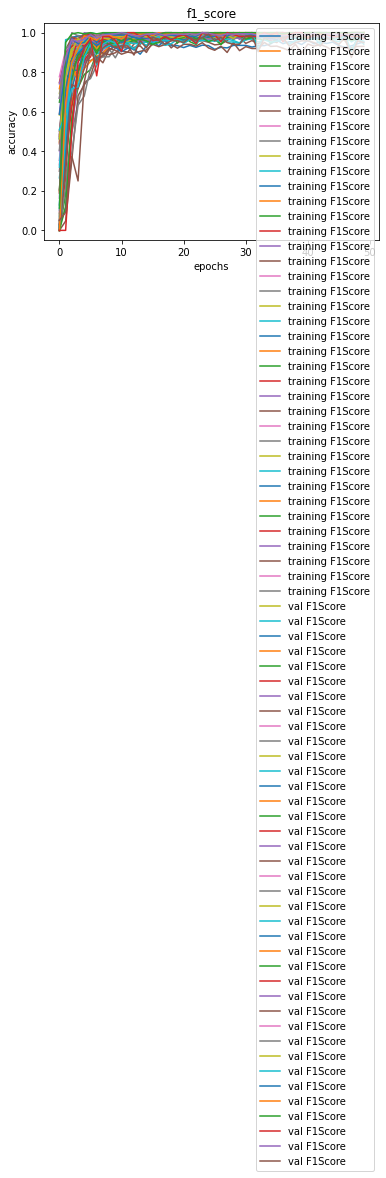

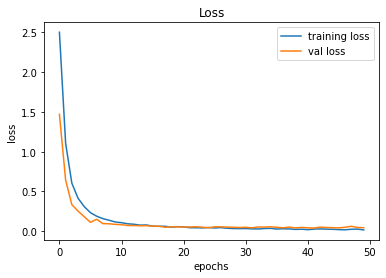

In [10]:
#plotting graphs for accuracy 
plt.figure(0)
plt.plot(history.history['f1_score'], label='training F1Score')
plt.plot(history.history['val_f1_score'], label='val F1Score')
plt.title('f1_score')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()
plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [17]:
# model.save('./saved_models/Trafic_Signs_CNN_special_instructions_signs.h5')

In [12]:
special_instructions_signs_classes = {'0':110,
'1':111,
'2':112,
'3':113,
'4':114,
'5':115,
'6':116,
'7':117,
'8':118,
'9':119,
'10':120,
'11':121,
'12':122,
'13':123,
'14':124,
'15':125,
'16':126,
'17':127,
'18':128,
'19':129,
'20':130,
'21':131,
'22':132,
'23':133,
'24':134,
'25':135,
'26':136,
'27':137,
'28':138,
'29':139,
'30':140,
'31':141,
'32':142,
'33':143,
'34':144,
'35':145,
'36':146,
'37':147,}

In [13]:
from sklearn.metrics import f1_score
df = pd.read_csv('./Data_images/Test_data.csv')
all_classes = []
predicted_classes = []

for c in range (110,148):
    for i in range(100):
        
        all_classes.append(c)
        # Считываем тестовый датасет
        image_path = df.loc[df['ClassId'] == c].values[i][1]
        classid = df.loc[df['ClassId'] == c].values[i][0]
        
        # Обрабатываем изображения
        image = cv2.imread(str('./Data_images/' + str(image_path)), 1) ## Считываем изображение
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB) ## переводим в оттенки серого
        image_resized = transform.resize(image, input_size)
        img_batch = np.expand_dims(image_resized,0)
        
        # Начинаем предсказание категории знака
        prediction = model.predict(img_batch)
        prediction = np.argmax(prediction, axis=1)
        predicted_classes.append(special_instructions_signs_classes[str(prediction[0])])
        
        if classid != special_instructions_signs_classes[(str(prediction[0]))]:
             print(classid,special_instructions_signs_classes[(str(prediction[0]))], prediction[0], image_path)


1/1 [==============================] - 0s 17ms/step
110 111 1 Test/110_6_12.png
1/1 [==============================] - 0s 18ms/step
110 111 1 Test/110_6_19.png
1/1 [==============================] - 0s 15ms/step
110 114 4 Test/110_6_17.png
1/1 [==============================] - 0s 30ms/step
111 110 0 Test/111_5_21.png
1/1 [==============================] - 0s 11ms/step
111 139 29 Test/111_1_2.png
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
111 139 29 Test/111_7_22.png
1/1 [==============================] - 0s 17ms/step
112 126 16 Test/112_2_17.png
1/1 [==============================] - 0s 17ms/step
112 126 16 Test/112_2_27.png
1/1 [==============================] - 0s 17ms/step
112 119 9 Test/112_3_18.png
1/1 [==============================] - 0s 16ms/step
112 135 25 Test/112_6_30.png
1/1 [==============================] - 0s 11ms/step
113 139 29 Test/113_5_30.png
1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 18ms/step
113 112 2 Test/113_3_8.png
1/1 [==============================] - 0s 10ms/step
113 139 29 Test/113_3_21.png
1/1 [==============================] - 0s 11ms/step
114 139 29 Test/114_5_36.png
1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 10ms/step
115 139 29 Test/115_3_25.png
1/1 [==============================] - 0s 16ms/step
115 139 29 Test/115_6_16.png
1/1 [==============================] - 0s 11ms/step
115 139 29 Test/115_5_36.png
1/1 [==============================] - 0s 16ms/step
115 139 29 Test/115_3_21.png
1/1 [==============================] - 0s 16ms/step
115 139 29 Test/115_3_29.png
1/1 [==============================] - 0s 5ms/step
115 139 29 Test/115_3_19.png
1/1 [==============================] - 0s 17ms/step
115 139 29 Test/115_6_25.png
1/1 [==============================] - 0s 4ms/step
115 113 3 Test/115_6_13.png
1/1 [==============================] - 0s 7ms/step
115 139 29 Test/115_2_36.png
1/1 [==============================] - 0s 16ms/step
115 139 29 Test/115_6_17.png
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
116 138 28 Test/116_7_35.png
1/1 [==============================] - 0s 18ms/step
116 139 29 Test/116_2_11.png
1/1 [==============================] - 0s 16ms/step
116 139 29 Test/116_1_29.png
1/1 [==============================] - 0s 16ms/step
116 125 15 Test/116_2_17.png
1/1 [==============================] - 0s 17ms/step
116 139 29 Test/116_2_9.png
1/1 [==============================] - 0s 16ms/step
116 138 28 Test/116_4_14.png
1/1 [==============================] - 0s 17ms/step
116 138 28 Test/116_7_38.png
1/1 [==============================] - 0s 16ms/step
116 131 21 Test/116_3_14.png
1/1 [==============================] - 0s 16ms/step
116 112 2 Test/116_3_16.png
1/1 [==============================] - 0s 16ms/step
117 130 20 Test/117_3_26.png
1/1 [==============================] - 0s 16ms/step
117 138 28 Test/117_7_27.png
1/1 [==============================] - 0s 16ms/step
117 138 28 Test/117_2_2.png
1/1 [==========================

1/1 [==============================] - 0s 16ms/step
117 114 4 Test/117_7_0.png
1/1 [==============================] - 0s 16ms/step
117 130 20 Test/117_3_14.png
1/1 [==============================] - 0s 16ms/step
117 114 4 Test/117_4_12.png
1/1 [==============================] - 0s 23ms/step
117 138 28 Test/117_7_19.png
1/1 [==============================] - 0s 20ms/step
117 114 4 Test/117_7_11.png
1/1 [==============================] - 0s 11ms/step
117 130 20 Test/117_3_6.png
1/1 [==============================] - 0s 17ms/step
117 138 28 Test/117_2_6.png
1/1 [==============================] - 0s 16ms/step
117 114 4 Test/117_2_5.png
1/1 [==============================] - 0s 16ms/step
117 112 2 Test/117_6_22.png
1/1 [==============================] - 0s 11ms/step
117 140 30 Test/117_6_33.png
1/1 [==============================] - 0s 16ms/step
117 114 4 Test/117_1_16.png
1/1 [==============================] - 0s 17ms/step
117 114 4 Test/117_1_38.png
1/1 [==============================] - 

1/1 [==============================] - 0s 15ms/step
119 138 28 Test/119_1_29.png
1/1 [==============================] - 0s 15ms/step
119 138 28 Test/119_2_35.png
1/1 [==============================] - 0s 17ms/step
119 138 28 Test/119_2_37.png
1/1 [==============================] - 0s 14ms/step
119 138 28 Test/119_1_26.png
1/1 [==============================] - 0s 10ms/step
119 112 2 Test/119_5_18.png
1/1 [==============================] - 0s 7ms/step
119 138 28 Test/119_4_37.png
1/1 [==============================] - 0s 7ms/step
119 138 28 Test/119_4_36.png
1/1 [==============================] - 0s 16ms/step
119 117 7 Test/119_7_13.png
1/1 [==============================] - 0s 16ms/step
119 112 2 Test/119_4_26.png
1/1 [==============================] - 0s 32ms/step
120 130 20 Test/120_3_10.png
1/1 [==============================] - 0s 16ms/step
120 130 20 Test/120_1_17.png
1/1 [==============================] - 0s 16ms/step
120 131 21 Test/120_1_25.png
1/1 [============================

1/1 [==============================] - 0s 16ms/step
120 138 28 Test/120_5_18.png
1/1 [==============================] - 0s 16ms/step
120 131 21 Test/120_7_25.png
1/1 [==============================] - 0s 15ms/step
120 138 28 Test/120_2_34.png
1/1 [==============================] - 0s 16ms/step
120 139 29 Test/120_4_21.png
1/1 [==============================] - 0s 9ms/step
120 138 28 Test/120_3_37.png
1/1 [==============================] - 0s 16ms/step
120 131 21 Test/120_1_30.png
1/1 [==============================] - 0s 17ms/step
121 138 28 Test/121_2_37.png
1/1 [==============================] - 0s 6ms/step
121 131 21 Test/121_5_1.png
1/1 [==============================] - 0s 17ms/step
121 120 10 Test/121_1_19.png
1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 7ms/step
122 137 27 Test/122_5_22.png
1/1 [==============================] - 0s 13ms/step
122 127 17 Test/122_1_19.png
1/1 [==============================] - 0s 16ms/step
122 123 13 Test/122_5_33.png
1/1 [==============================] - 0s 15ms/step
122 128 18 Test/122_4_9.png
1/1 [==============================] - 0s 16ms/step
122 127 17 Test/122_1_30.png
1/1 [==============================] - 0s 9ms/step
122 139 29 Test/122_1_24.png
1/1 [==============================] - 0s 16ms/step
122 127 17 Test/122_4_24.png
1/1 [==============================] - 0s 16ms/step
122 139 29 Test/122_3_25.png
1/1 [==============================] - 0s 14ms/step
122 132 22 Test/122_4_12.png
1/1 [==============================] - 0s 16ms/step
122 127 17 Test/122_4_27.png
1/1 [==============================] - 0s 16ms/step
122 139 29 Test/122_3_19.png
1/1 [==============================] - 0s 16ms/step
122 132 22 Test/122_4_20.png
1/1 [==========================

1/1 [==============================] - 0s 16ms/step
123 122 12 Test/123_4_11.png
1/1 [==============================] - 0s 18ms/step
123 122 12 Test/123_4_35.png
1/1 [==============================] - 0s 16ms/step
123 122 12 Test/123_4_20.png
1/1 [==============================] - 0s 16ms/step
123 122 12 Test/123_4_22.png
1/1 [==============================] - 0s 16ms/step
124 116 6 Test/124_5_8.png
1/1 [==============================] - 0s 15ms/step
124 116 6 Test/124_4_26.png
1/1 [==============================] - 0s 7ms/step
124 126 16 Test/124_3_18.png
1/1 [==============================] - 0s 13ms/step
124 116 6 Test/124_4_10.png
1/1 [==============================] - 0s 17ms/step
124 116 6 Test/124_4_8.png
1/1 [==============================] - 0s 16ms/step
124 116 6 Test/124_4_17.png
1/1 [==============================] - 0s 16ms/step
124 125 15 Test/124_3_22.png
1/1 [==============================] - 0s 16ms/step
124 136 26 Test/124_3_11.png
1/1 [==============================]

1/1 [==============================] - 0s 16ms/step
125 110 0 Test/125_5_6.png
1/1 [==============================] - 0s 16ms/step
125 138 28 Test/125_2_32.png
1/1 [==============================] - 0s 16ms/step
125 141 31 Test/125_4_4.png
1/1 [==============================] - 0s 31ms/step
125 124 14 Test/125_7_5.png
1/1 [==============================] - 0s 16ms/step
125 116 6 Test/125_7_6.png
1/1 [==============================] - 0s 13ms/step
126 117 7 Test/126_3_25.png
1/1 [==============================] - 0s 16ms/step
126 117 7 Test/126_3_26.png
1/1 [==============================] - 0s 16ms/step
126 114 4 Test/126_4_2.png
1/1 [==============================] - 0s 6ms/step
126 116 6 Test/126_4_13.png
1/1 [==============================] - 0s 17ms/step
126 117 7 Test/126_1_25.png
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
126 114 4 Test/126_2_32.png
1/1 [==============================] - 0s 17ms/step
126 117 7 Test/126_3_21.png
1/1 [==============================] - 0s 15ms/step
126 130 20 Test/126_4_11.png
1/1 [==============================] - 0s 16ms/step
126 130 20 Test/126_4_21.png
1/1 [==============================] - 0s 7ms/step
126 130 20 Test/126_4_20.png
1/1 [==============================] - 0s 10ms/step
126 131 21 Test/126_7_13.png
1/1 [==============================] - 0s 16ms/step
126 131 21 Test/126_7_21.png
1/1 [==============================] - 0s 16ms/step
127 139 29 Test/127_4_16.png
1/1 [==============================] - 0s 16ms/step
127 111 1 Test/127_1_25.png
1/1 [==============================] - 0s 16ms/step
127 139 29 Test/127_4_28.png
1/1 [==============================] - 0s 22ms/step
127 139 29 Test/127_4_30.png
1/1 [==============================] - 0s 16ms/step
127 122 12 Test/127_2_28.png
1/1 [===========================

1/1 [==============================] - 0s 16ms/step
127 115 5 Test/127_4_5.png
1/1 [==============================] - 0s 16ms/step
128 132 22 Test/128_3_22.png
1/1 [==============================] - 0s 25ms/step
128 132 22 Test/128_3_4.png
1/1 [==============================] - 0s 18ms/step
129 139 29 Test/129_7_24.png
1/1 [==============================] - 0s 16ms/step
129 139 29 Test/129_3_21.png
1/1 [==============================] - 0s 13ms/step
129 139 29 Test/129_7_13.png
1/1 [==============================] - 0s 9ms/step
129 139 29 Test/129_7_17.png
1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 16ms/step
129 139 29 Test/129_3_27.png
1/1 [==============================] - 0s 14ms/step
129 139 29 Test/129_5_5.png
1/1 [==============================] - 0s 16ms/step
130 114 4 Test/130_1_29.png
1/1 [==============================] - 0s 17ms/step
130 114 4 Test/130_1_25.png
1/1 [==============================] - 0s 18ms/step
130 114 4 Test/130_1_27.png
1/1 [==============================] - 0s 11ms/step
130 112 2 Test/130_7_2.png
1/1 [==============================] - 0s 16ms/step
130 112 2 Test/130_7_1.png
1/1 [==============================] - 0s 16ms/step
130 114 4 Test/130_7_19.png
1/1 [==============================] - 0s 18ms/step
130 114 4 Test/130_1_8.png
1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 16ms/step
131 130 20 Test/131_7_27.png
1/1 [==============================] - 0s 8ms/step
131 114 4 Test/131_4_22.png
1/1 [==============================] - 0s 11ms/step
131 130 20 Test/131_1_17.png
1/1 [==============================] - 0s 15ms/step
131 130 20 Test/131_2_24.png
1/1 [==============================] - 0s 16ms/step
132 130 20 Test/132_1_34.png
1/1 [==============================] - 0s 16ms/step
132 130 20 Test/132_1_11.png
1/1 [==============================] - 0s 9ms/step
132 131 21 Test/132_6_26.png
1/1 [==============================] - 0s 23ms/step
132 130 20 Test/132_1_32.png
1/1 [==============================] - 0s 2ms/step


1/1 [==============================] - 0s 22ms/step
132 139 29 Test/132_7_6.png
1/1 [==============================] - 0s 16ms/step
132 138 28 Test/132_1_4.png
1/1 [==============================] - 0s 17ms/step
132 138 28 Test/132_6_19.png
1/1 [==============================] - 0s 16ms/step
132 130 20 Test/132_1_36.png
1/1 [==============================] - 0s 2ms/step
132 138 28 Test/132_6_14.png
1/1 [==============================] - 0s 16ms/step
132 129 19 Test/132_4_9.png
1/1 [==============================] - 0s 16ms/step
132 131 21 Test/132_1_9.png
1/1 [==============================] - 0s 16ms/step
133 139 29 Test/133_3_26.png
1/1 [==============================] - 0s 16ms/step
133 139 29 Test/133_3_6.png
1/1 [==============================] - 0s 16ms/step
133 139 29 Test/133_3_29.png
1/1 [==============================] - 0s 16ms/step
133 138 28 Test/133_3_25.png
1/1 [==============================] - 0s 15ms/step
133 139 29 Test/133_4_21.png
1/1 [=============================

1/1 [==============================] - 0s 12ms/step
134 130 20 Test/134_2_16.png
1/1 [==============================] - 0s 7ms/step
134 139 29 Test/134_5_30.png
1/1 [==============================] - 0s 14ms/step
134 110 0 Test/134_6_20.png
1/1 [==============================] - 0s 2ms/step
134 135 25 Test/134_5_19.png
1/1 [==============================] - 0s 2ms/step
134 116 6 Test/134_5_22.png
1/1 [==============================] - 0s 10ms/step
134 139 29 Test/134_5_12.png
1/1 [==============================] - 0s 11ms/step
134 139 29 Test/134_4_29.png
1/1 [==============================] - 0s 11ms/step
134 135 25 Test/134_3_27.png
1/1 [==============================] - 0s 16ms/step
134 139 29 Test/134_2_11.png
1/1 [==============================] - 0s 16ms/step
134 135 25 Test/134_5_9.png
1/1 [==============================] - 0s 17ms/step
135 138 28 Test/135_4_14.png
1/1 [==============================] - 0s 16ms/step
135 138 28 Test/135_4_37.png
1/1 [=============================

1/1 [==============================] - 0s 17ms/step
135 138 28 Test/135_4_33.png
1/1 [==============================] - 0s 21ms/step
136 116 6 Test/136_7_21.png
1/1 [==============================] - 0s 12ms/step
136 138 28 Test/136_7_33.png
1/1 [==============================] - 0s 19ms/step
136 138 28 Test/136_7_14.png
1/1 [==============================] - 0s 17ms/step
136 120 10 Test/136_7_12.png
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step
137 139 29 Test/137_4_35.png
1/1 [==============================] - 0s 6ms/step
138 139 29 Test/138_6_9.png
1/1 [==============================] - 0s 14ms/step
138 139 29 Test/138_6_12.png
1/1 [==============================] - 0s 12ms/step
138 139 29 Test/138_7_21.png
1/1 [==============================] - 0s 16ms/step
138 114 4 Test/138_6_14.png
1/1 [==============================] - 0s 17ms/step
138 114 4 Test/138_6_6.png
1/1 [==============================] - 0s 6ms/step
138 139 29 Test/138_7_26.png
1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 15ms/step
138 139 29 Test/138_7_11.png
1/1 [==============================] - 0s 16ms/step
138 130 20 Test/138_3_38.png
1/1 [==============================] - 0s 13ms/step
139 138 28 Test/139_7_36.png
1/1 [==============================] - 0s 8ms/step
139 138 28 Test/139_7_0.png
1/1 [==============================] - 0s 16ms/step
139 138 28 Test/139_2_2.png
1/1 [==============================] - 0s 17ms/step
139 138 28 Test/139_7_32.png
1/1 [==============================] - 0s 16ms/step
139 138 28 Test/139_7_35.png
1/1 [==============================] - 0s 17ms/step
139 138 28 Test/139_7_34.png
1/1 [==============================] - 0s 17ms/step
139 138 28 Test/139_7_8.png
1/1 [==============================] - 0s 16ms/step
139 131 21 Test/139_7_12.png
1/1 [==============================] - 0s 16ms/step
139 138 28 Test/139_2_0.png
1/1 [==============================] - 0s 17ms/step
139 138 28 Test/139_7_33.png
1/1 [============================

1/1 [==============================] - 0s 17ms/step
140 139 29 Test/140_2_24.png
1/1 [==============================] - 0s 11ms/step
140 139 29 Test/140_6_30.png
1/1 [==============================] - 0s 16ms/step
140 138 28 Test/140_5_24.png
1/1 [==============================] - 0s 16ms/step
140 138 28 Test/140_3_22.png
1/1 [==============================] - 0s 22ms/step
140 139 29 Test/140_2_10.png
1/1 [==============================] - 0s 27ms/step
141 138 28 Test/141_5_33.png
1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 17ms/step
141 147 37 Test/141_7_37.png
1/1 [==============================] - 0s 16ms/step
141 147 37 Test/141_7_1.png
1/1 [==============================] - 0s 2ms/step
142 112 2 Test/142_3_11.png
1/1 [==============================] - 0s 29ms/step
142 112 2 Test/142_3_5.png
1/1 [==============================] - 0s 10ms/step
142 110 0 Test/142_7_2.png
1/1 [==============================] - 0s 17ms/step
142 121 11 Test/142_6_22.png
1/1 [==============================] - 0s 5ms/step
142 112 2 Test/142_7_0.png
1/1 [==============================] - 0s 16ms/step
142 112 2 Test/142_3_38.png
1/1 [==============================] - 0s 15ms/step
142 114 4 Test/142_7_10.png
1/1 [==============================] - 0s 10ms/step
142 146 36 Test/142_6_11.png
1/1 [==============================] - 0s 16ms/step
142 146 36 Test/142_2_19.png
1/1 [==============================] - 0s 11ms/step
142 112 2 Test/142_3_35.png
1/1 [==============================] - 0s

1/1 [==============================] - 0s 19ms/step
143 142 32 Test/143_1_16.png
1/1 [==============================] - 0s 16ms/step
143 135 25 Test/143_5_11.png
1/1 [==============================] - 0s 31ms/step
143 138 28 Test/143_3_28.png
1/1 [==============================] - 0s 16ms/step
143 146 36 Test/143_7_13.png
1/1 [==============================] - 0s 25ms/step
143 141 31 Test/143_4_24.png
1/1 [==============================] - 0s 2ms/step
143 138 28 Test/143_3_20.png
1/1 [==============================] - 0s 31ms/step
143 142 32 Test/143_1_18.png
1/1 [==============================] - 0s 32ms/step
143 139 29 Test/143_2_27.png
1/1 [==============================] - 0s 15ms/step
143 145 35 Test/143_1_26.png
1/1 [==============================] - 0s 14ms/step
143 110 0 Test/143_3_14.png
1/1 [==============================] - 0s 6ms/step
143 135 25 Test/143_5_12.png
1/1 [==============================] - 0s 16ms/step
143 135 25 Test/143_3_5.png
1/1 [===========================

1/1 [==============================] - 0s 2ms/step
144 139 29 Test/144_5_18.png
1/1 [==============================] - 0s 16ms/step
144 139 29 Test/144_2_29.png
1/1 [==============================] - 0s 16ms/step
144 139 29 Test/144_2_4.png
1/1 [==============================] - 0s 16ms/step
145 141 31 Test/145_4_18.png
1/1 [==============================] - 0s 16ms/step
145 141 31 Test/145_6_3.png
1/1 [==============================] - 0s 29ms/step
145 141 31 Test/145_6_22.png
1/1 [==============================] - 0s 16ms/step
145 141 31 Test/145_6_34.png
1/1 [==============================] - 0s 16ms/step
145 138 28 Test/145_6_18.png
1/1 [==============================] - 0s 16ms/step
145 147 37 Test/145_6_20.png
1/1 [==============================] - 0s 16ms/step
145 141 31 Test/145_6_5.png
1/1 [==============================] - 0s 16ms/step
145 141 31 Test/145_6_33.png
1/1 [==============================] - 0s 16ms/step
145 141 31 Test/145_1_5.png
1/1 [============================

1/1 [==============================] - 0s 16ms/step
146 140 30 Test/146_2_21.png
1/1 [==============================] - 0s 5ms/step
146 139 29 Test/146_7_16.png
1/1 [==============================] - 0s 2ms/step
146 138 28 Test/146_7_1.png
1/1 [==============================] - 0s 4ms/step
146 131 21 Test/146_1_20.png
1/1 [==============================] - 0s 2ms/step
146 138 28 Test/146_3_33.png
1/1 [==============================] - 0s 23ms/step
146 116 6 Test/146_6_29.png
1/1 [==============================] - 0s 15ms/step
146 140 30 Test/146_7_28.png
1/1 [==============================] - 0s 13ms/step
146 140 30 Test/146_7_21.png
1/1 [==============================] - 0s 5ms/step
146 139 29 Test/146_3_32.png
1/1 [==============================] - 0s 16ms/step
146 140 30 Test/146_1_19.png
1/1 [==============================] - 0s 14ms/step
146 138 28 Test/146_7_22.png
1/1 [==============================] - 0s 16ms/step
147 138 28 Test/147_5_18.png
1/1 [==============================

1/1 [==============================] - 0s 7ms/step
147 141 31 Test/147_7_22.png
1/1 [==============================] - 0s 8ms/step
147 138 28 Test/147_5_32.png
1/1 [==============================] - 0s 16ms/step
147 146 36 Test/147_4_11.png
1/1 [==============================] - 0s 17ms/step
147 146 36 Test/147_1_32.png
1/1 [==============================] - 0s 3ms/step
147 141 31 Test/147_6_21.png
1/1 [==============================] - 0s 16ms/step


In [14]:
print (f1_score(all_classes, predicted_classes, average='weighted'))

0.910386054495753


Text(0.5, 0.98, 'Plot of confusion matrix')

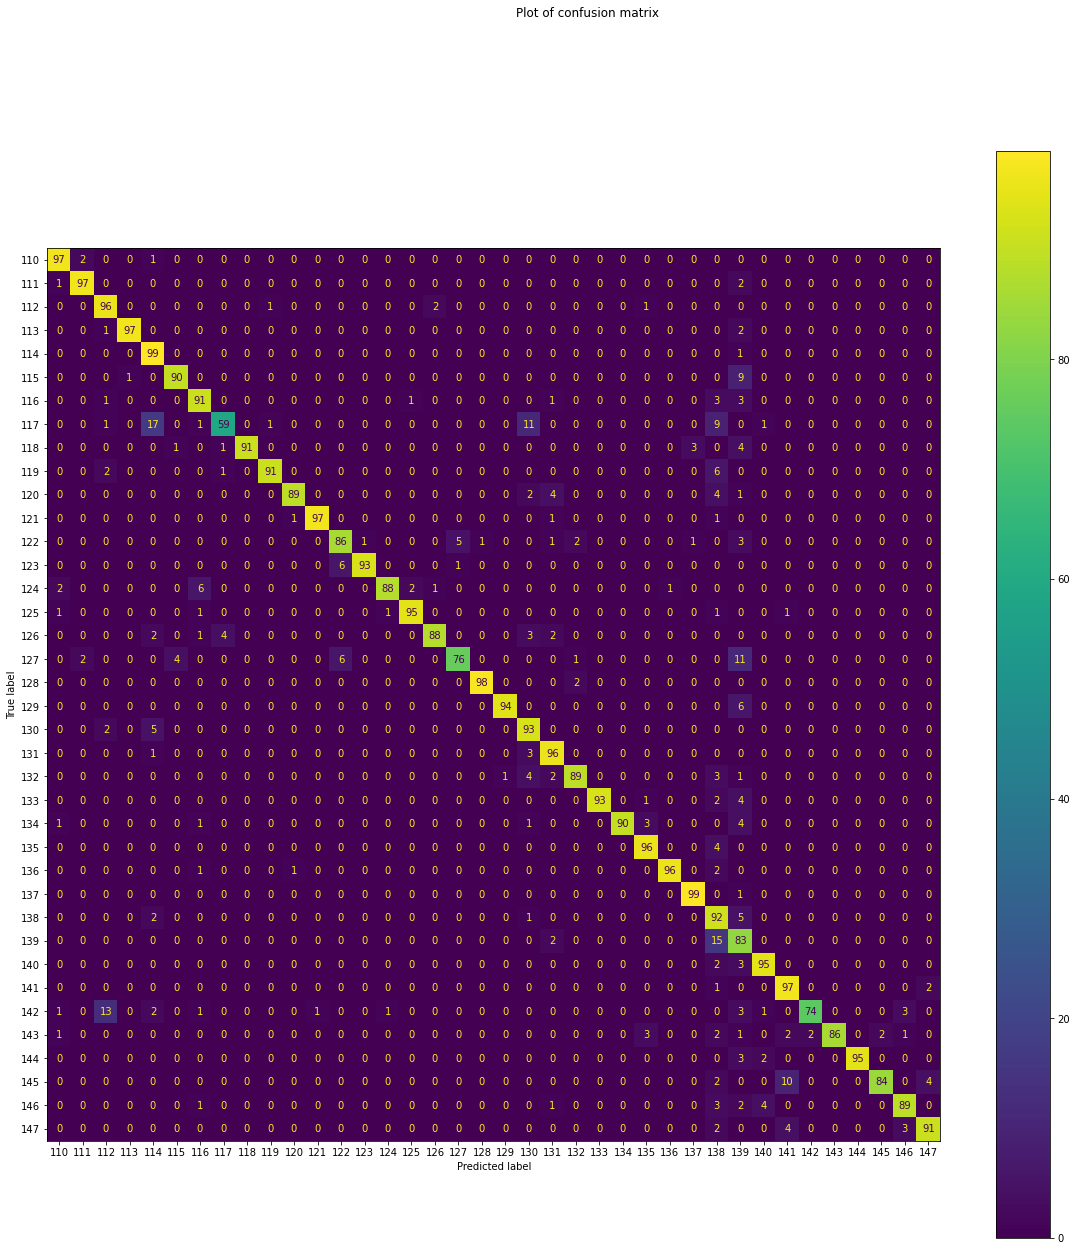

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
display = ConfusionMatrixDisplay.from_predictions(all_classes, predicted_classes)
fig = display.figure_
fig.set_figwidth(20)
fig.set_figheight(20) 
fig.suptitle('Plot of confusion matrix')